In [2]:
import xarray as xr
from  cartopy import crs as ccrs
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import rc

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi'] = 300

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

# version = "no_transform"
# version = "sqrt"
# version = "transform_0.1"

test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_no_transform_frames = torch.load(f"samples_no_transform.pt", map_location="cpu").numpy().reshape(-1, 64, 64)
sample_sqrt_frames = torch.load(f"samples_sqrt.pt", map_location="cpu").numpy().reshape(-1, 64, 64)
sample_transform_frames = torch.load(f"samples_transform_0.1.pt", map_location="cpu").numpy().reshape(-1, 64, 64)

test_cell_means = np.mean(test_frames, axis=(0,)).reshape(1, 64, 64)
sample_no_transform_cell_means = np.mean(sample_no_transform_frames, axis=(0,)).reshape(1, 64, 64)
sample_sqrt_cell_means = np.mean(sample_sqrt_frames, axis=(0,)).reshape(1, 64, 64)
sample_transform_cell_means = np.mean(sample_transform_frames, axis=(0,)).reshape(1, 64, 64)

diff_means_no_transform = (sample_no_transform_cell_means - test_cell_means) / test_cell_means
diff_means_sqrt = (sample_sqrt_cell_means - test_cell_means) / test_cell_means
diff_means_transform = (sample_transform_cell_means - test_cell_means) / test_cell_means

Mean absolute difference in cell means:  0.14273678 0.31448364 0.22676823


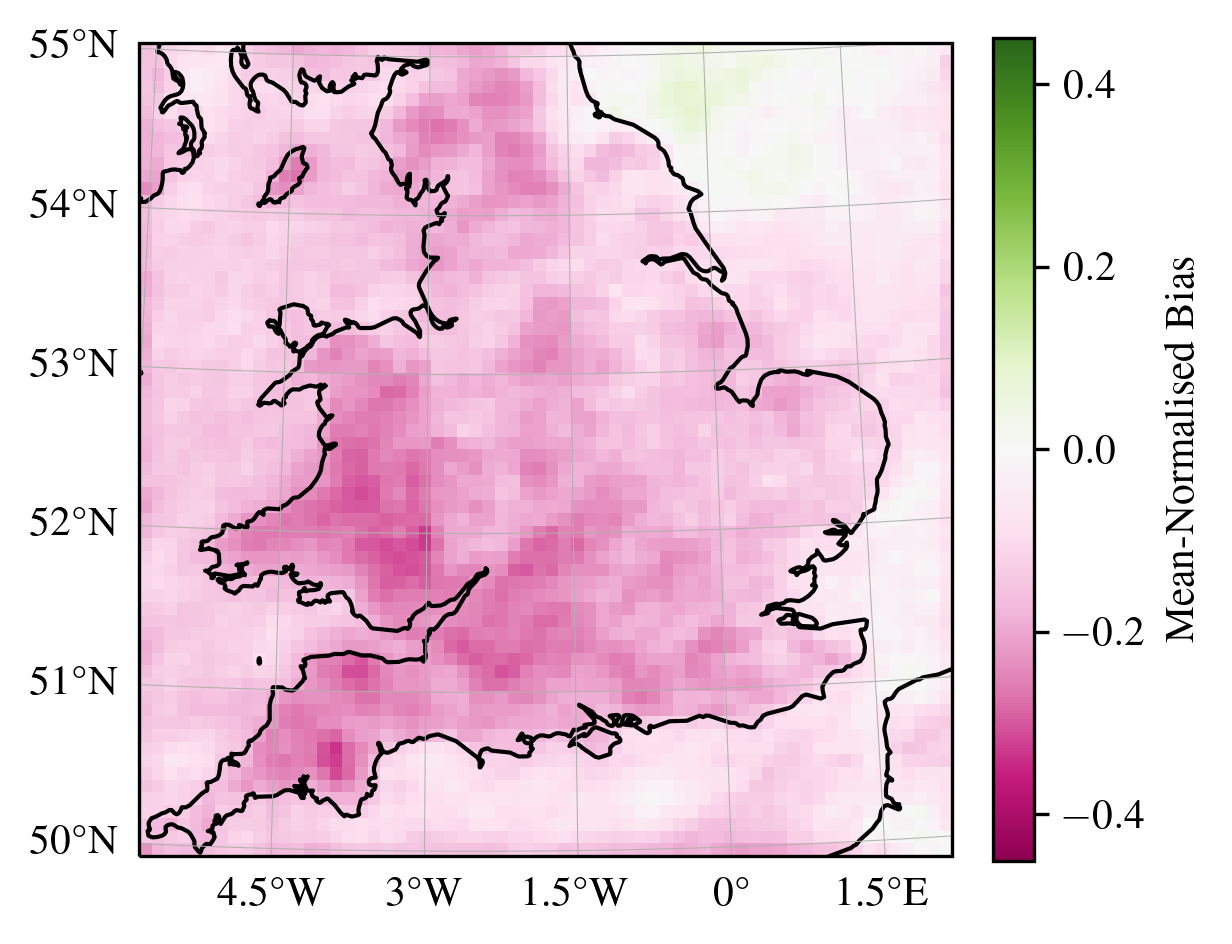

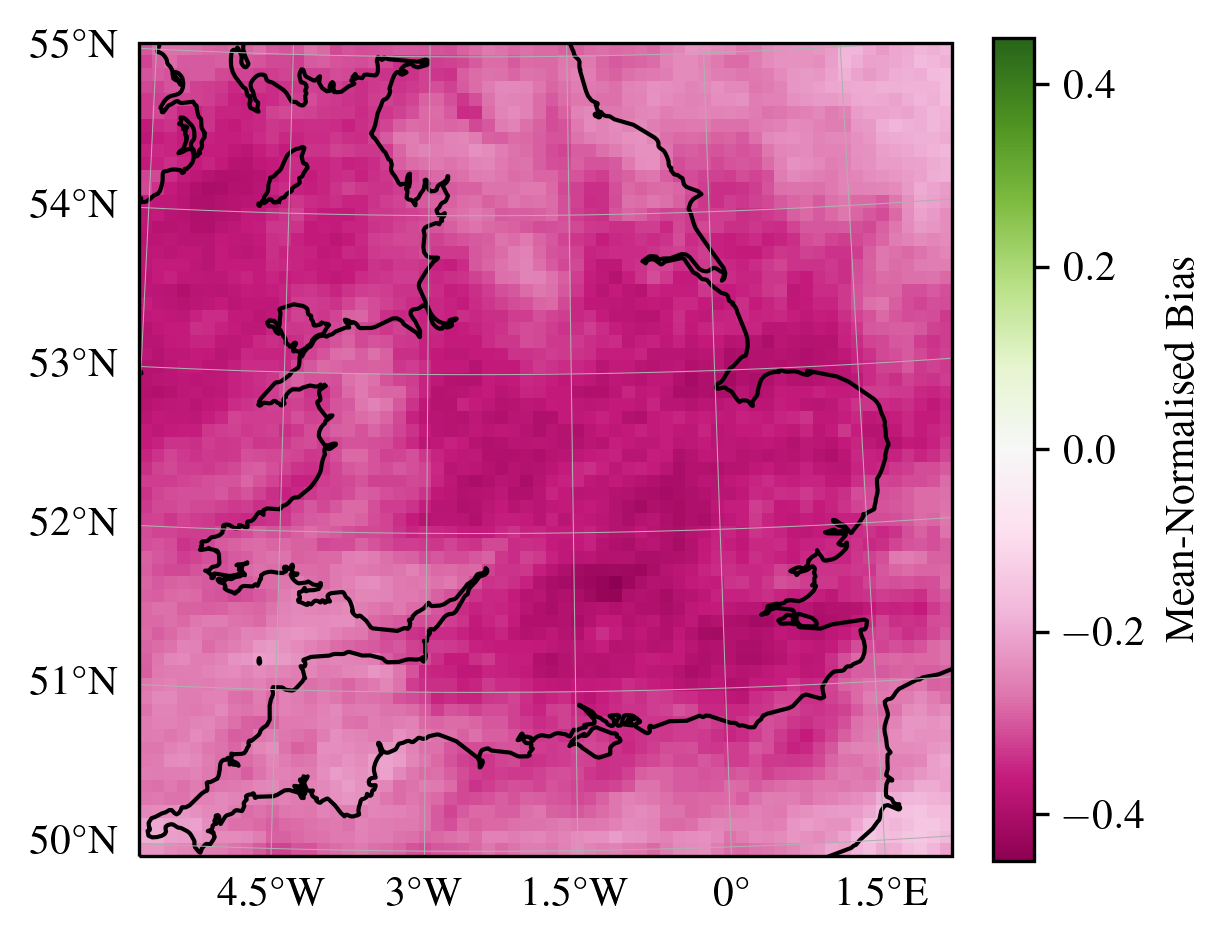

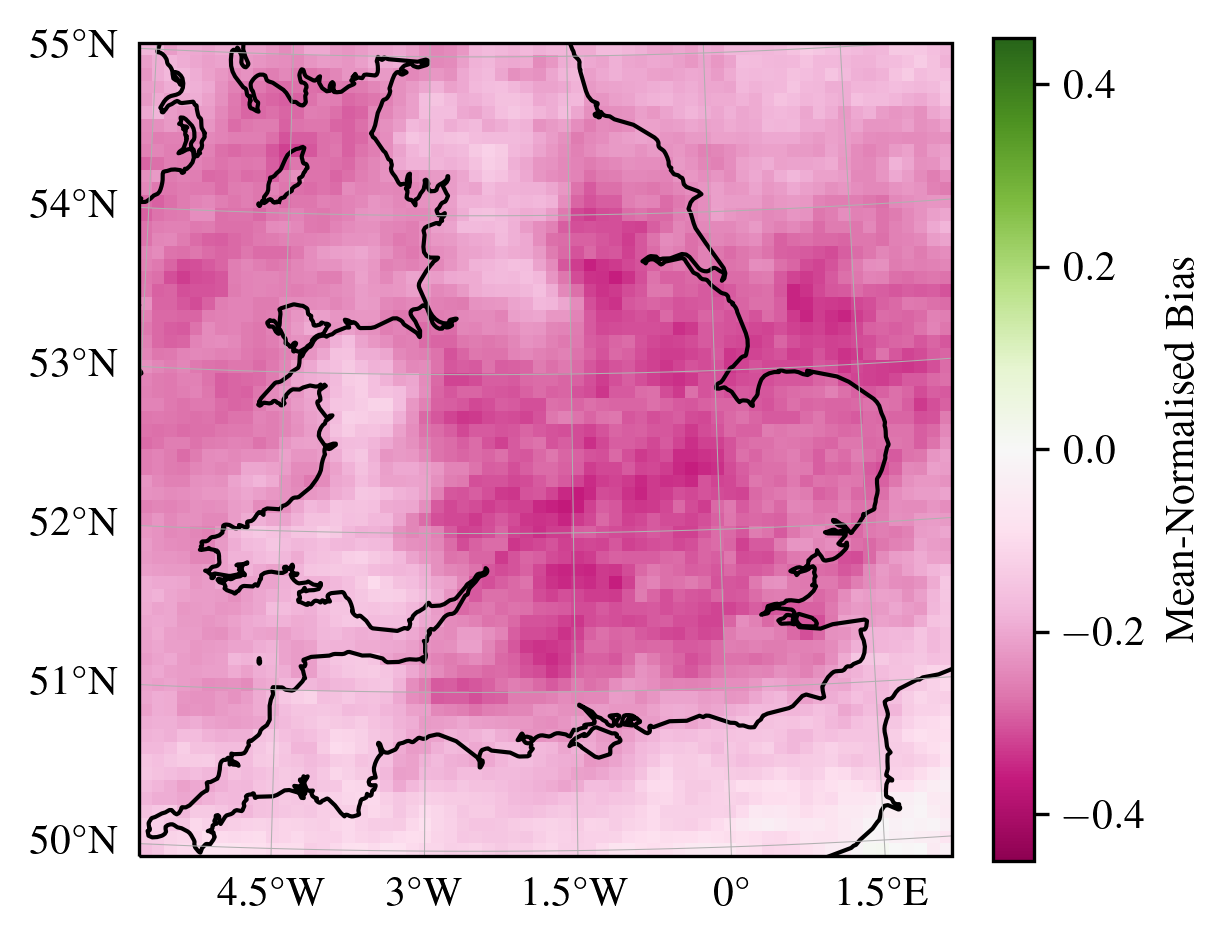

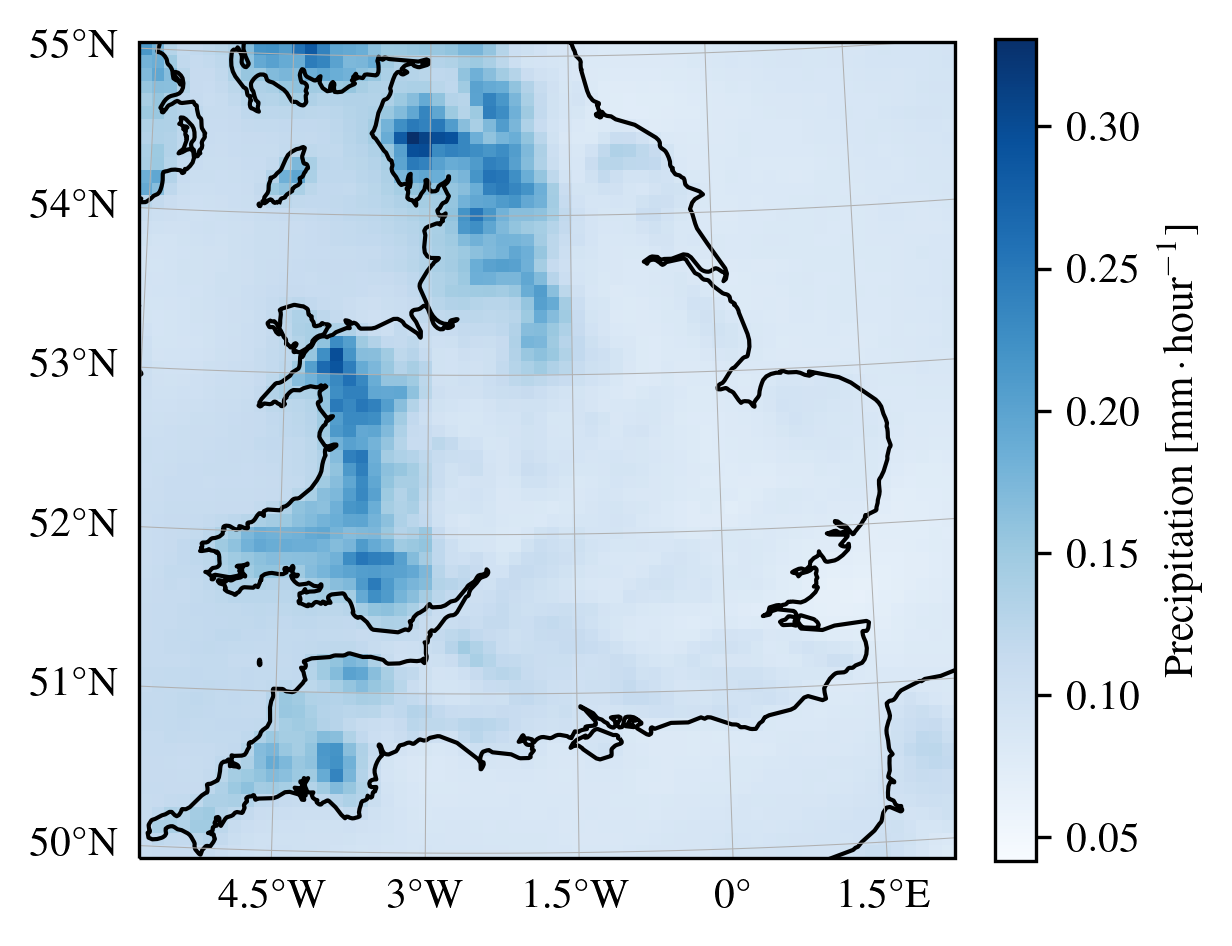

In [63]:
test_sample_min = min(np.min(test_cell_means), np.min(sample_sqrt_cell_means), np.min(sample_transform_cell_means))
test_sample_max = max(np.max(test_cell_means), np.max(sample_sqrt_cell_means), np.max(sample_transform_cell_means))

diff_abs_max = max(np.abs(np.min(diff_means_sqrt)), np.abs(np.max(diff_means_sqrt)), np.abs(np.min(diff_means_transform)), np.abs(np.max(diff_means_transform)))

def plot_means_diff(da, type):
    if type == "means":
        vmin = test_sample_min
        vmax = test_sample_max
        label = "Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]"
        cmap = "Blues"
    elif type == "diff":
        vmin = -diff_abs_max
        vmax = diff_abs_max
        label = "Mean-Normalised Bias"
        cmap = "PiYG"
    _, ax = plt.subplots(
        figsize=(4, 4), 
        subplot_kw={'projection': cp_model_rotated_pole},
        layout="constrained",
    )
    da.isel(time=0).plot.pcolormesh(
        ax=ax,
        x="longitude",
        y="latitude",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "shrink": 0.7,
            "label": label,
        }
    )
    ax.gridlines(linewidth = 0.25, draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.plot()

diff_no_transform_da = xr.DataArray(diff_means_no_transform, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
diff_sqrt_da = xr.DataArray(diff_means_sqrt, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
diff_transform_da = xr.DataArray(diff_means_transform, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})

print("Mean absolute difference in cell means: ", np.mean(np.abs(diff_no_transform_da.values)), np.mean(np.abs(diff_sqrt_da.values)), np.mean(np.abs(diff_transform_da.values)))

plot_means_diff(diff_no_transform_da, type="diff")
plt.savefig("examples/bias_no_transform.png", bbox_inches="tight", pad_inches=0.02)
plot_means_diff(diff_sqrt_da, type="diff")
plt.savefig("examples/bias_sqrt.png", bbox_inches="tight", pad_inches=0.02)
plot_means_diff(diff_transform_da, type="diff")
plt.savefig("examples/bias_transform.png", bbox_inches="tight", pad_inches=0.02)

test_da = xr.DataArray(test_cell_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
no_transform_da = xr.DataArray(sample_no_transform_cell_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
# sample_da = xr.DataArray(sample_cell_means, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
plot_means_diff(test_da, type="means")
plt.savefig("examples/ukcp18_spatial_means.png", bbox_inches="tight", pad_inches=0.02)
# plot_means_diff(sample_da, type="means")

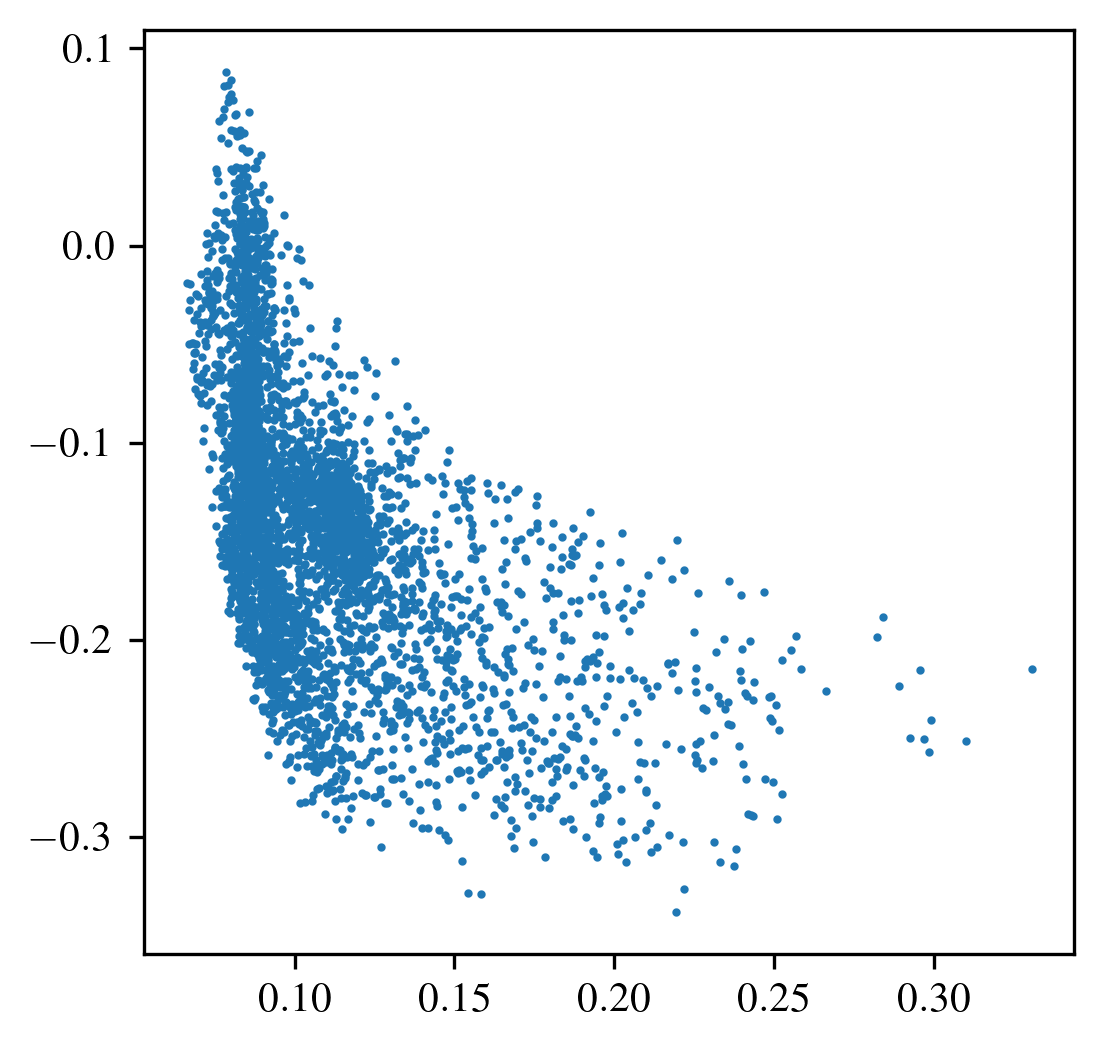

In [60]:
plt.figure(figsize=(4, 4))
plt.scatter(test_cell_means, diff_means_no_transform, s = 1)
plt.show()

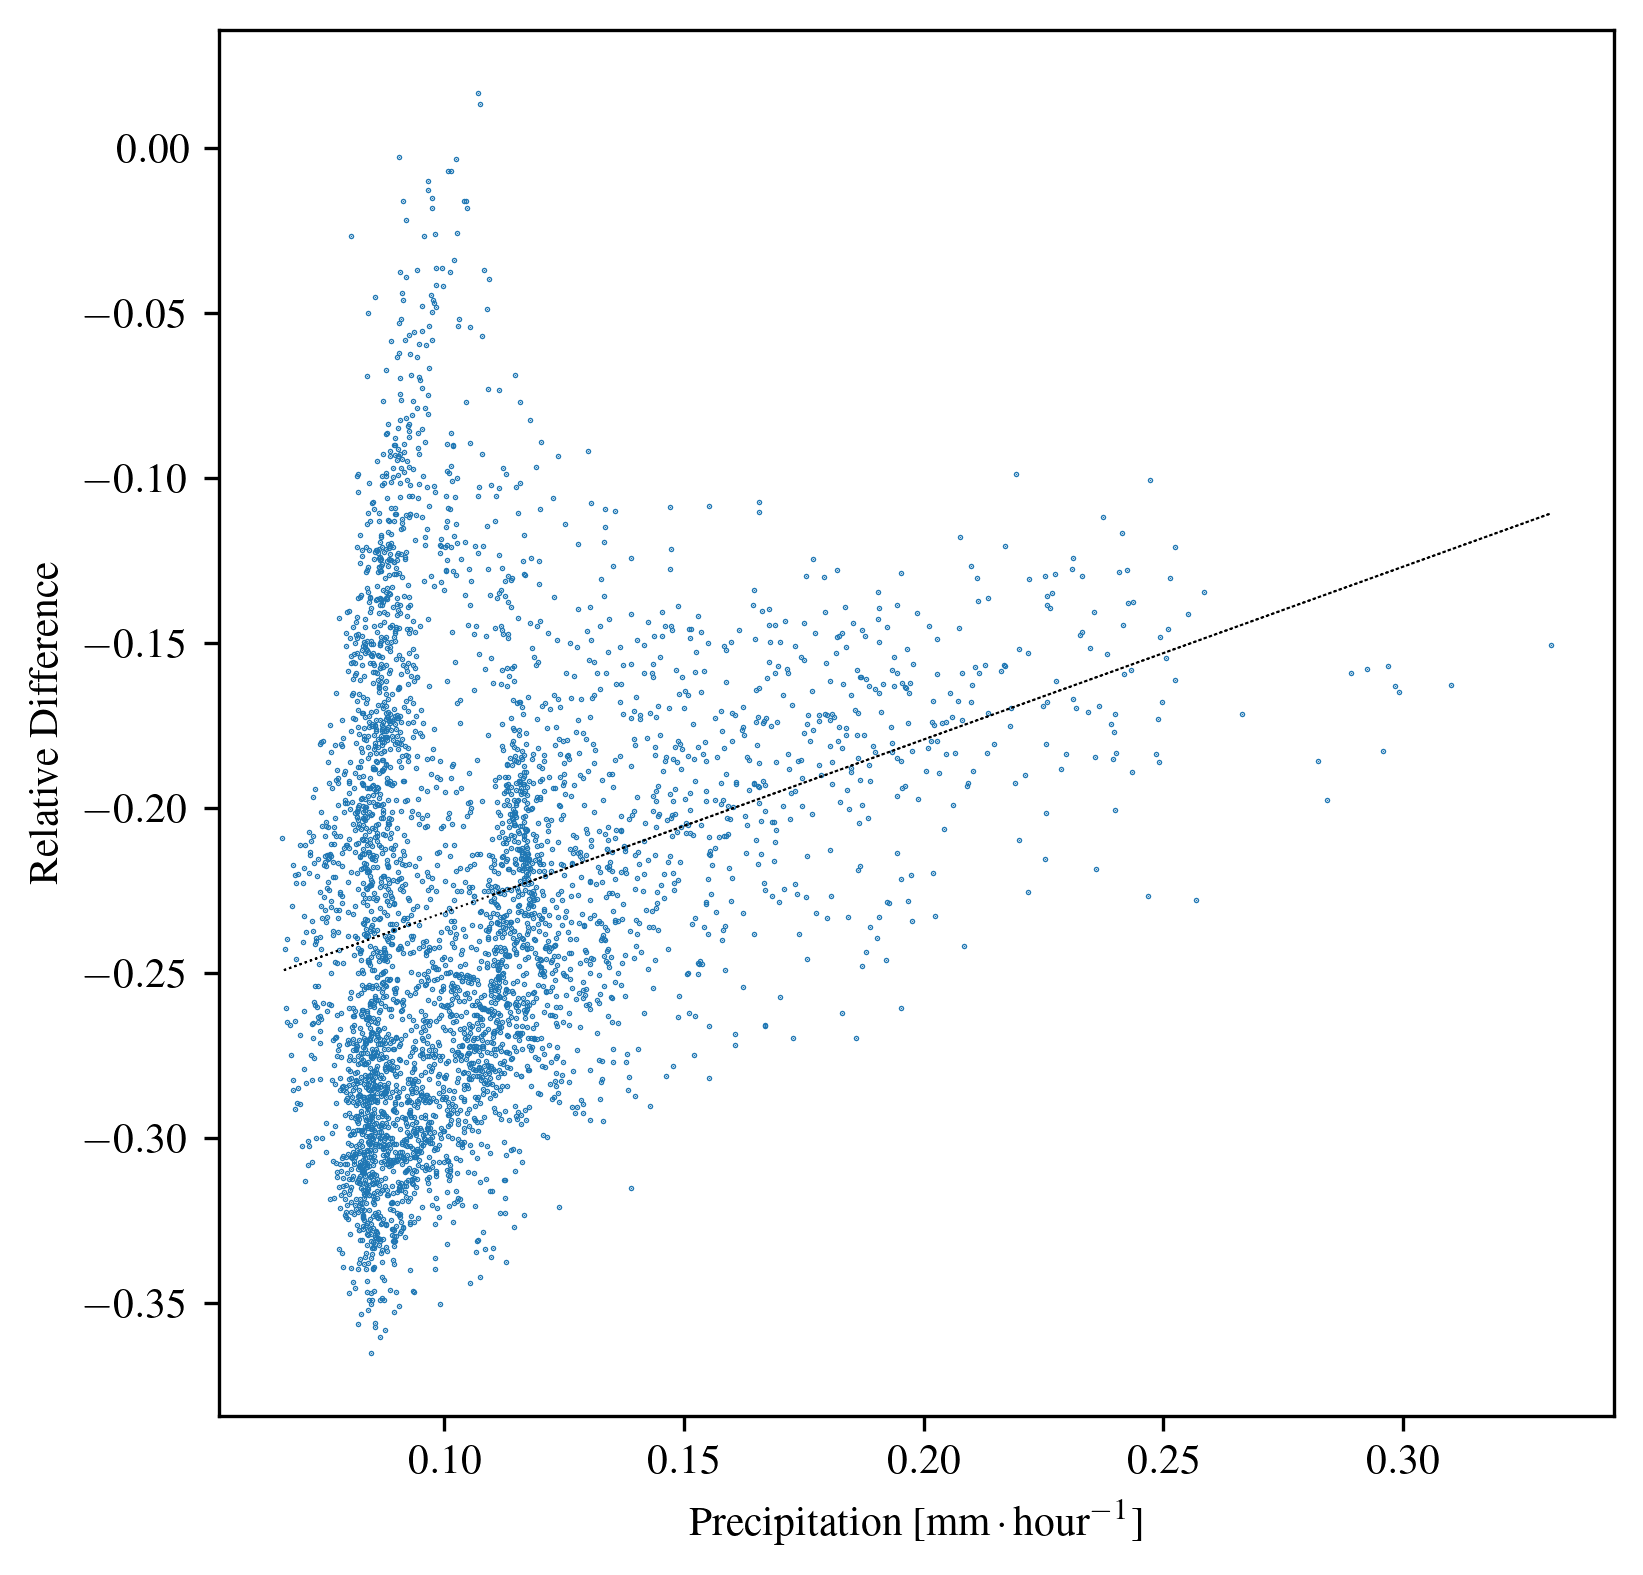

In [43]:
plt.figure(figsize=(6, 6))
plt.scatter(test_cell_means, diff_means, s=0.1)
# Plot line of best fit
m, b = np.polyfit(test_cell_means.flatten(), diff_means.flatten(), 1)
plt.plot(test_cell_means.flatten(), m*test_cell_means.flatten() + b, color="black", linewidth=0.5, linestyle=":")
plt.xlabel("Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]")
plt.ylabel("Relative Difference")
plt.show()

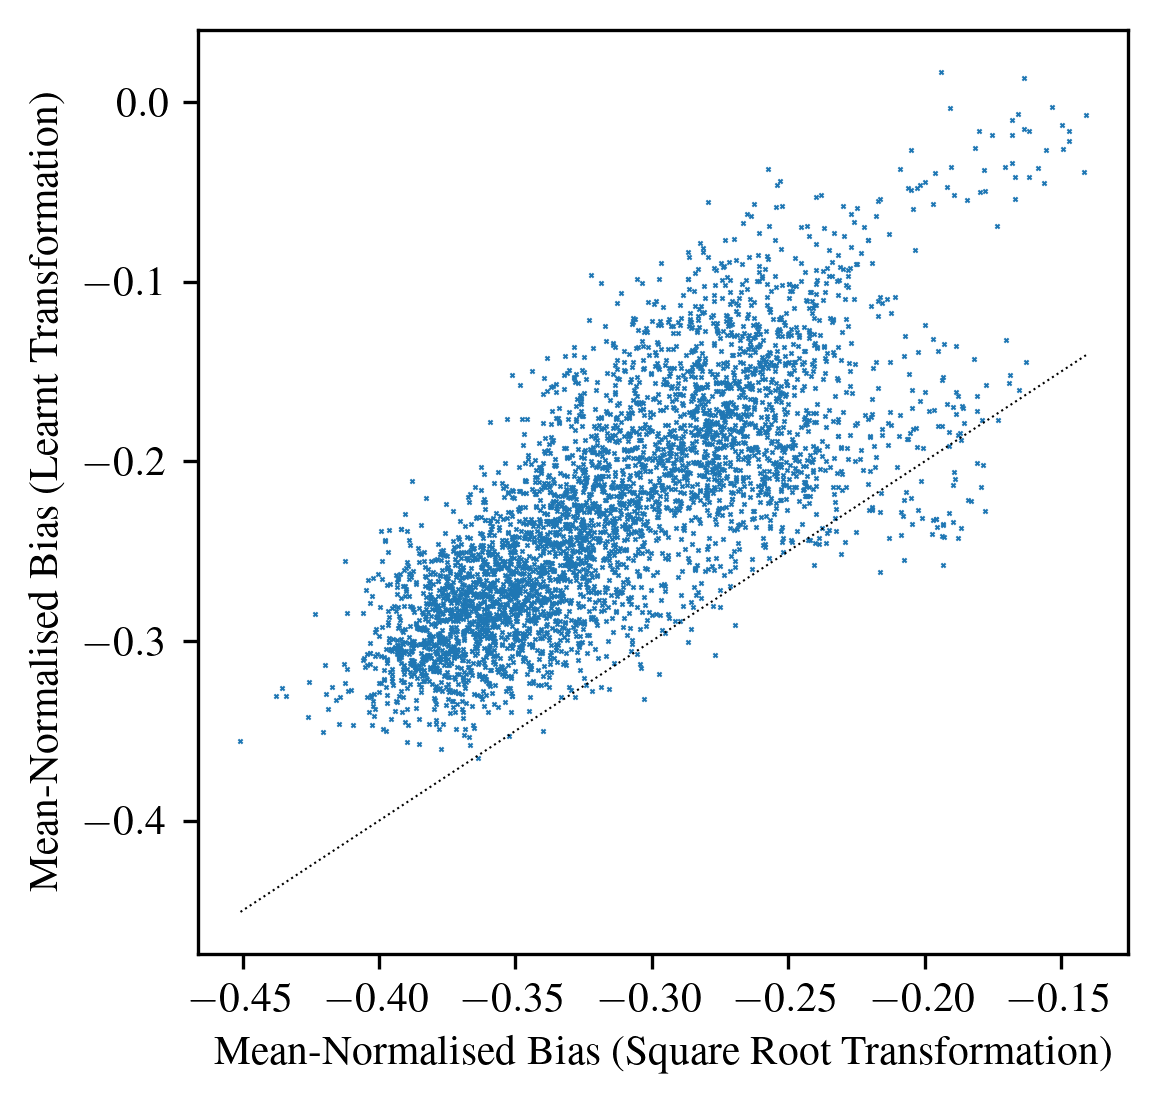

In [50]:
plt.figure(figsize=(4, 4))

plt.scatter(diff_sqrt_da.values.flatten(), diff_transform_da.values.flatten(), s = 1, linewidth = 0.5, marker = 'x')
# plt.plot([-diff_abs_max, diff_abs_max], [-diff_abs_max, diff_abs_max], color="black", linewidth=0.5, linestyle=":")

xs = np.linspace(diff_sqrt_da.min(), diff_sqrt_da.max())
ys = xs
plt.plot(xs, ys, color="black", linewidth=0.5, linestyle=":")

plt.xlabel("Mean-Normalised Bias (Square Root Transformation)")
plt.ylabel("Mean-Normalised Bias (Learnt Transformation)")
plt.savefig("examples/bias_scatter.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

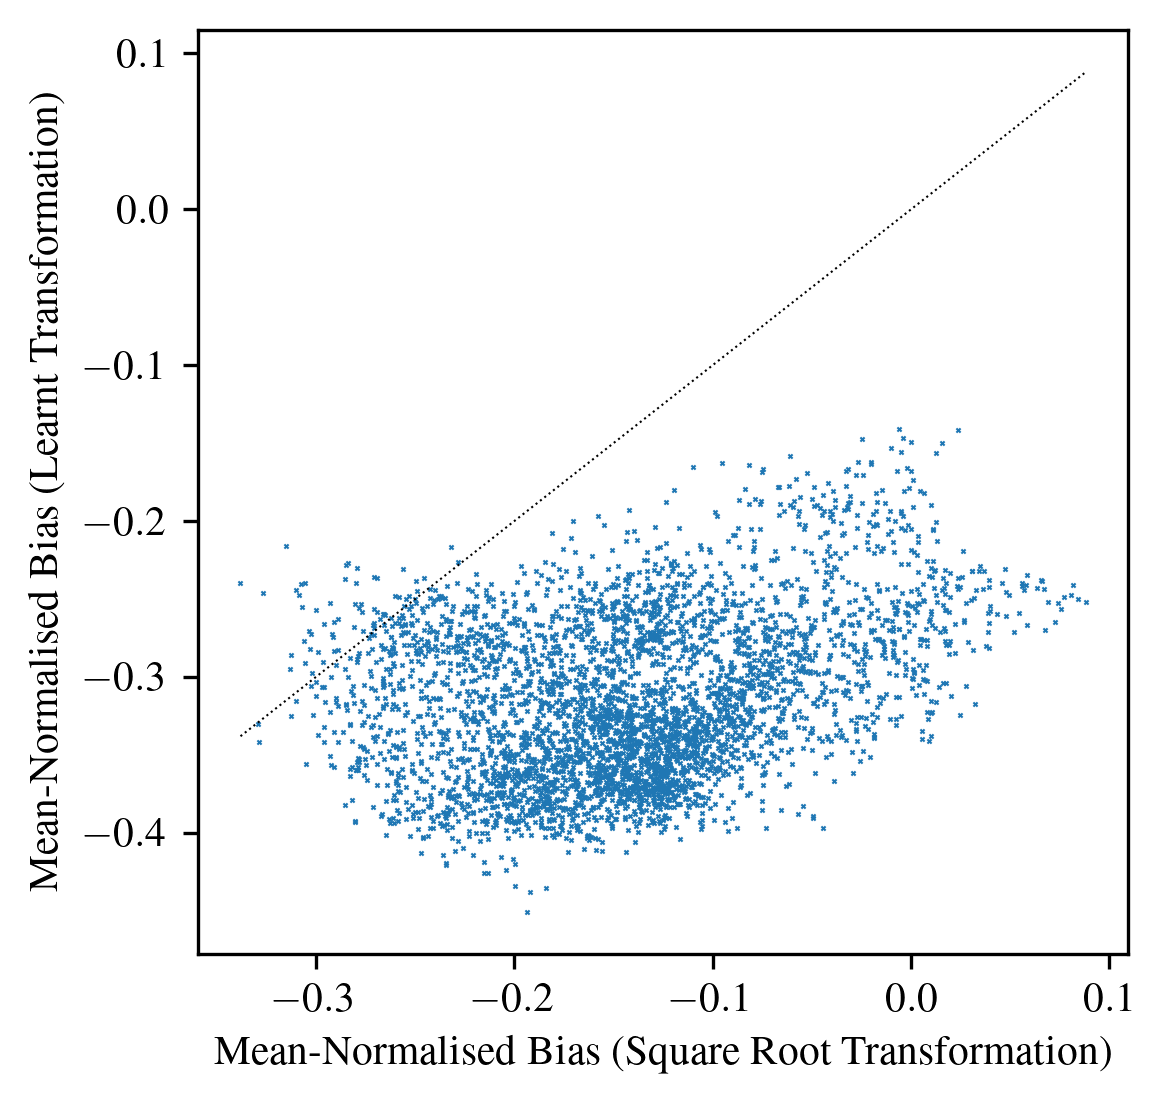

In [53]:
plt.figure(figsize=(4, 4))

plt.scatter(diff_no_transform_da.values.flatten(), diff_sqrt_da.values.flatten(), s = 1, linewidth = 0.5, marker = 'x')

xs = np.linspace(diff_no_transform_da.min(), diff_no_transform_da.max())
ys = xs
plt.plot(xs, ys, color="black", linewidth=0.5, linestyle=":")

plt.xlabel("Mean-Normalised Bias (Square Root Transformation)")
plt.ylabel("Mean-Normalised Bias (Learnt Transformation)")
plt.savefig("examples/bias_scatter.png", bbox_inches="tight", pad_inches=0.02)
plt.show()